In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

#Statistical LTV
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data

#ML Approach to LTV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

**Data Preprocessing**

In [23]:
from google.colab import files
uploaded = files.upload()

Saving Online Retail.csv to Online Retail.csv


       InvoiceNo StockCode                       Description  Quantity  \
479301    577152     23206            LUNCH BAG APPLE DESIGN        10   
385027    570187     22619         SET OF 6 SOLDIER SKITTLES         1   
30923     538883     21700       BIG DOUGHNUT FRIDGE MAGNETS         1   
270394    560567     22613       PACK OF 20 SPACEBOY NAPKINS         1   
139881    548361     22139  RETROSPOT TEA SET CERAMIC 11 PC          3   

               InvoiceDate  UnitPrice  CustomerID         Country       date  \
479301 2011-11-18 09:53:00       1.65     14277.0          France 2011-11-18   
385027 2011-10-07 15:09:00       7.46         NaN  United Kingdom 2011-10-07   
30923  2010-12-14 15:56:00       8.47         NaN  United Kingdom 2010-12-14   
270394 2011-07-19 13:57:00       1.63         NaN  United Kingdom 2011-07-19   
139881 2011-03-30 15:38:00       4.95     16092.0  United Kingdom 2011-03-30   

            time  hour  weekend  dayofweek  Revenue  
479301  09:53:00    

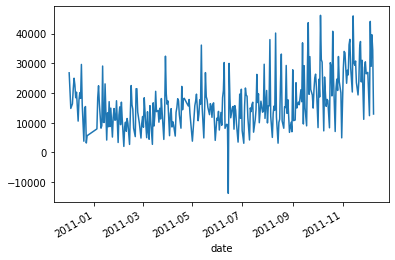

In [25]:
#Read in
data = pd.read_csv('Online Retail.csv', engine='python')
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate, format = '%Y-%m-%d %H:%M')

#Datetime transformation
data['date'] = pd.to_datetime(data.InvoiceDate.dt.date)
data['time'] = data.InvoiceDate.dt.time
data['hour'] = data['time'].apply(lambda x: x.hour)
data['weekend'] = data['date'].apply(lambda x: x.weekday() in [5, 6])
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)
#Get revenue column
data['Revenue'] = data['Quantity'] * data['UnitPrice']

print(data.sample(5))

#Plots a timeseries of total sales
data.groupby('date')['Quantity'].sum().plot()
#Prints the total number of days between start and end
print(data['date'].max() - data['date'].min())


Training Features Period - from 2011-01-01 until 2011-06-11

Training Target Period - from 2011-06-12 until 2011-09-09

Testing Features Period - from 2011-04-02 until 2011-09-10

Testing Target Period - from 2011-09-11 until 2011-12-09

In [27]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'date', 'time', 'hour', 'weekend',
       'dayofweek', 'Revenue'],
      dtype='object')

In [30]:
def get_features(data, feature_start, feature_end, target_start, target_end):
    """
    Function that outputs the features and targets on the user-level.
    Inputs:
        * data - a dataframe with raw data
        * feature_start - a string start date of feature period
        * feature_end - a  string end date of feature period
        * target_start - a  string start date of target period
        * target_end - a  string end date of target period
    """
    #Double check the periods length
    features_data = data.loc[(data.date >= feature_start) & (data.date <= feature_end), :]
    print(f'Using data from {(pd.to_datetime(feature_end) - pd.to_datetime(feature_start)).days} days')
    print(f'To predict {(pd.to_datetime(target_end) - pd.to_datetime(target_start)).days} days')
    
    #Transactions data features
    total_rev = features_data.groupby('CustomerID')['Revenue'].sum().rename('total_revenue')
    recency = (features_data.groupby('CustomerID')['date'].max() - features_data.groupby('CustomerID')['date'].min()).apply(lambda x: x.days).rename('recency')
    frequency = features_data.groupby('CustomerID')['InvoiceNo'].count().rename('frequency')
    t = features_data.groupby('CustomerID')['date'].min().apply(lambda x: (datetime(2011, 6, 11) - x).days).rename('t')
    time_between = (t / frequency).rename('time_between')
    avg_basket_value = (total_rev / frequency).rename('avg_basket_value')
    avg_basket_size = (features_data.groupby('CustomerID')['Quantity'].sum() / frequency).rename('avg_basket_Size')
    returns = features_data.loc[features_data['Revenue'] < 0, :].groupby('CustomerID')['InvoiceNo'].count().rename('num_returns')
    hour = features_data.groupby('CustomerID')['hour'].median().rename('purchase_hour_med')
    dow = features_data.groupby('CustomerID')['dayofweek'].median().rename('purchase_dow_med')
    weekend =  features_data.groupby('CustomerID')['weekend'].mean().rename('purchase_weekend_prop')
    train_data = pd.DataFrame(index = data.index)
    train_data = train_data.join([total_rev, recency, frequency, t, time_between, avg_basket_value, avg_basket_size, returns, hour, dow, weekend])
    train_data = train_data.fillna(0)
    
    #Target data
    target_data = data.loc[(data.date >= target_start) & (data.date <= target_end), :]
    target_quant = target_data.groupby(['CustomerID'])['date'].nunique()
    target_rev = target_data.groupby(['CustomerID'])['Revenue'].sum().rename('target_rev')
    train_data = train_data.join(target_rev).fillna(0)
    
    return train_data.iloc[:, :-1], train_data.iloc[:, -1] #X and Y


#Dates are taken from the discussion above
X_train, y_train = get_features(data, '2011-01-01', '2011-06-11', '2011-06-12', '2011-09-09')
X_test, y_test = get_features(data, '2011-04-02', '2011-09-10', '2011-09-11', '2011-12-09')

print(X_train.head())

Using data from 161 days
To predict 89 days
Using data from 161 days
To predict 89 days
   total_revenue  recency  frequency    t  time_between  avg_basket_value  \
0            0.0      0.0        0.0  0.0           0.0               0.0   
1            0.0      0.0        0.0  0.0           0.0               0.0   
2            0.0      0.0        0.0  0.0           0.0               0.0   
3            0.0      0.0        0.0  0.0           0.0               0.0   
4            0.0      0.0        0.0  0.0           0.0               0.0   

   avg_basket_Size  num_returns  purchase_hour_med  purchase_dow_med  \
0              0.0          0.0                0.0               0.0   
1              0.0          0.0                0.0               0.0   
2              0.0          0.0                0.0               0.0   
3              0.0          0.0                0.0               0.0   
4              0.0          0.0                0.0               0.0   

   purchase_week

In [ ]:
#DNN
def build_model():
    model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(X_train.columns), ]),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])
    
    return model

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=50)

model = build_model()
#Should take 10 sec
early_history = model.fit(X_train, y_train, 
                    epochs=1000, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop])


In [ ]:
def evaluate(actual, sales_prediction):
    print(f"Total Sales Actual: {np.round(actual.sum())}")
    print(f"Total Sales Predicted: {np.round(sales_prediction.sum())}")
    print(f"Individual R2 score: {r2_score(actual, sales_prediction)} ")
    print(f"Individual Mean Absolute Error: {mean_absolute_error(actual, sales_prediction)}")
    plt.scatter(sales_prediction, actual)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')      
    plt.show()

#Predicting
dnn_preds = model.predict(X_test).ravel()

evaluate(y_test, dnn_preds)

In [ ]:
##PRE-PROCESSING
#Context data for the revenue (date & customerID)
id_lookup = data[['CustomerID', 'InvoiceNo', 'date']].drop_duplicates()
id_lookup.index = id_lookup['InvoiceNo']
id_lookup = id_lookup.drop('InvoiceNo', axis=1)
transactions_data = pd.DataFrame(data.groupby('InvoiceNo')['Revenue'].sum()).join(id_lookup)

#Spit into train - test
rfm_train_test = calibration_and_holdout_data(transactions_data, 'CustomerID', 'date',
                                        calibration_period_end='2011-09-10',
                                        monetary_value_col = 'Revenue')   

#Selecting only customers with positive value in the calibration period (otherwise Gamma-Gamma model doesn't work)
rfm_train_test = rfm_train_test.loc[rfm_train_test['monetary_value_cal'] > 0, :]

##TRAINING
#Train the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(rfm_train_test['frequency_cal'], rfm_train_test['recency_cal'], rfm_train_test['T_cal'])

#Train Gamma-Gamma
print(rfm_train_test[['monetary_value_cal', 'frequency_cal']].corr())
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(rfm_train_test['frequency_cal'],
        rfm_train_test['monetary_value_cal'])

##PREDICTION
#Predict the expected number of transactions in the next 89 days
predicted_bgf = bgf.predict(89,
                        rfm_train_test['frequency_cal'], 
                        rfm_train_test['recency_cal'], 
                        rfm_train_test['T_cal'])
trans_pred = predicted_bgf.fillna(0)

#Predict the average order value
monetary_pred = ggf.conditional_expected_average_profit(rfm_train_test['frequency_cal'],
                                        rfm_train_test['monetary_value_cal'])

#Putting it all together
sales_pred = trans_pred * monetary_pred


In [ ]:
#First 98.5% of data
no_out = compare_df.loc[(compare_df['actual'] <= np.quantile(compare_df['actual'], 0.985)), :]

#Distribution of DNN
sns.distplot(no_out['actual'])
sns.distplot(no_out['dnn_preds'])
plt.title('Actual vs DNN Predictions')
plt.show()

In [ ]:
#Distribution of BG/NBD + Gamma-Gamma
sns.distplot(no_out['actual'])
sns.distplot(no_out['stat_pred'])
plt.title('Actual vs BG/NBD Predictions')
plt.show()

In [ ]:
top_n = int(np.round(compare_df.shape[0] * 0.2))
print(f'Selecting the first {top_n} users')

#Selecting IDs
dnn_ids = compare_df['dnn_preds'].sort_values(ascending=False).index[:top_n].values
stat_ids = compare_df['stat_pred'].sort_values(ascending=False).index[:top_n].values

#Filtering the data
eval_subset = data.loc[data.date >= '2011-09-10', :]

#Sums
dnn_rev = eval_subset.loc[eval_subset.CustomerID.isin(dnn_ids), 'Revenue'].sum() 
stat_rev = eval_subset.loc[eval_subset.CustomerID.isin(stat_ids), 'Revenue'].sum()


print(f'Top 20% selected by DNN have generated {np.round(dnn_rev)}')
print(f'Top 20% selected by BG/NBD and Gamma Gamma have generated {np.round(stat_rev)}')
print(f'Thats {np.round(dnn_rev - stat_rev)} of marginal revenue')
